In [26]:
import pandas as pd

# Paths to the .csv.gz files
file_path_2024 = '../data/Origin Destination Data 2024.csv.gz'
file_path_2023 = '../data/Origin Destination Data 2023.csv.gz'

# Define column names
column_names = ['date', 'hour', 'origin', 'destination', 'count']

# Load the .csv.gz files without reading the first row as column names
df_2024 = pd.read_csv(file_path_2024, header=None, names=column_names)
df_2023 = pd.read_csv(file_path_2023, header=None, names=column_names)

# Merge the two DataFrames
df = pd.concat([df_2023, df_2024], ignore_index=True)

# Combine 'date' and 'hour' columns into a single datetime column
df['datetime'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')

# Set the 'datetime' column as the index
df.set_index('datetime', inplace=True)

# Trim the data to the specified timestamp range
start_date = pd.Timestamp("2023-06-21 15:00:00")
end_date = pd.Timestamp("2024-06-20 21:00:00")
df = df.loc[start_date:end_date]

# Display the first few rows
df.head()

,date,hour,origin,destination,count
datetime,,,,,
2023-06-21 15:00:00,2023-06-21,15,12TH,12TH,4
2023-06-21 15:00:00,2023-06-21,15,12TH,16TH,4
2023-06-21 15:00:00,2023-06-21,15,12TH,19TH,5
2023-06-21 15:00:00,2023-06-21,15,12TH,24TH,5
2023-06-21 15:00:00,2023-06-21,15,12TH,ANTC,8


In [27]:
filtered_df = df[(df['origin'] == 'EMBR') | (df['destination'] == 'EMBR')]
filtered_df.head()

,date,hour,origin,destination,count
datetime,,,,,
2023-06-21 15:00:00,2023-06-21,15,12TH,EMBR,21
2023-06-21 15:00:00,2023-06-21,15,16TH,EMBR,35
2023-06-21 15:00:00,2023-06-21,15,19TH,EMBR,21
2023-06-21 15:00:00,2023-06-21,15,24TH,EMBR,20
2023-06-21 15:00:00,2023-06-21,15,ANTC,EMBR,10


In [28]:
# Create a new DataFrame for commuters with the timestamp as index and 'arrival'/'departure' columns
df_commuters = filtered_df[filtered_df['destination'] == 'EMBR'].groupby('datetime')['count'].sum().rename('arrival').to_frame()
df_commuters['departure'] = filtered_df[filtered_df['origin'] == 'EMBR'].groupby('datetime')['count'].sum()

# Fill NaN values with 0 for arrivals and departures
df_commuters = df_commuters.fillna(0)
df_commuters['arrival'] = df_commuters['arrival'].astype(int)
df_commuters['departure'] = df_commuters['departure'].astype(int)

# Add a 'balance' column as the difference between 'arrival' and 'departure'
df_commuters['balance'] = df_commuters['arrival'] - df_commuters['departure']

df_commuters.head()

,arrival,departure,balance
datetime,,,
2023-06-21 15:00:00,523,1438,-915
2023-06-21 16:00:00,641,2870,-2229
2023-06-21 17:00:00,1097,4079,-2982
2023-06-21 18:00:00,777,2836,-2059
2023-06-21 19:00:00,262,1353,-1091


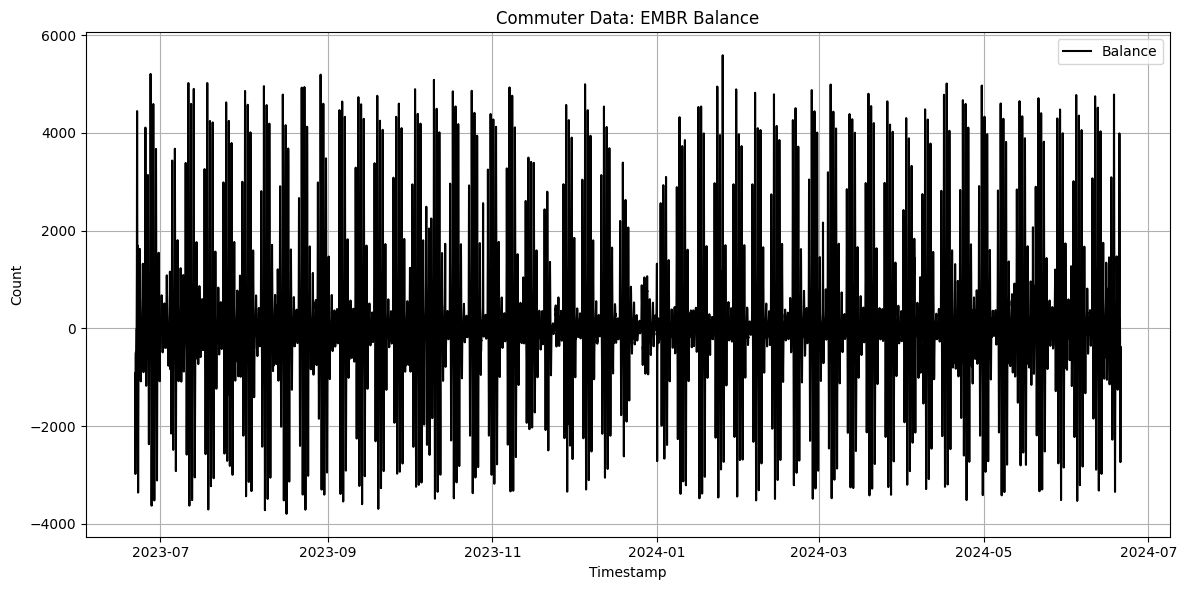

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_commuters.index, df_commuters['balance'], label='Balance', color='black')

# Customize the plot
plt.title("Commuter Data: EMBR Balance")
plt.xlabel("Timestamp")
plt.ylabel("Count")
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

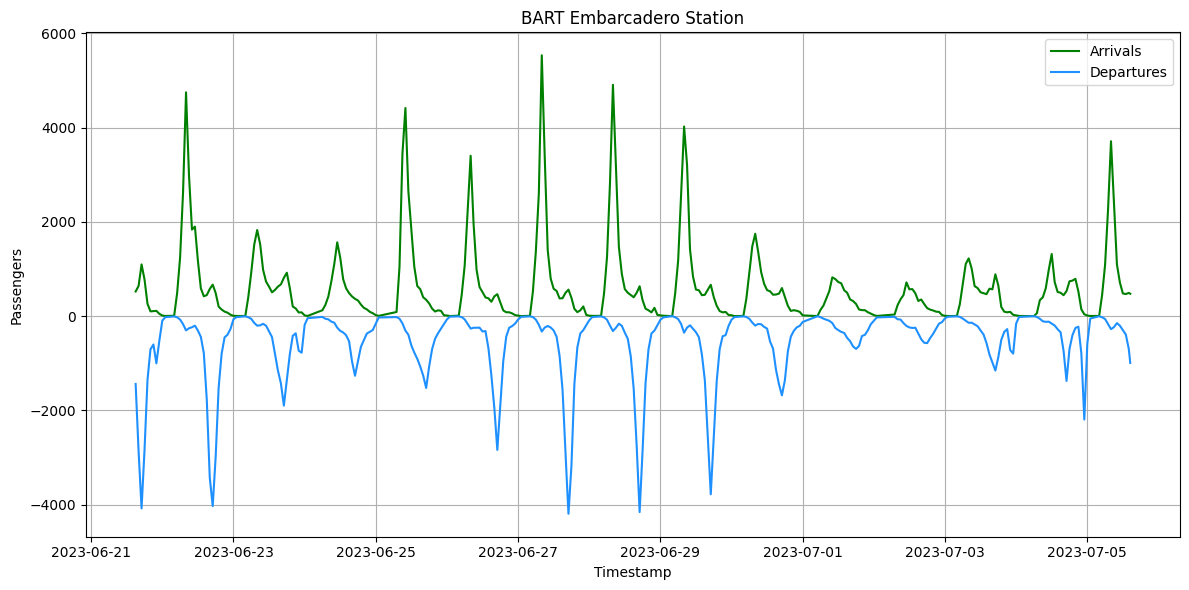

In [38]:
# Resample the data to a 30-minute interval with linear interpolation
df_commuters_resampled = df_commuters.resample("30min").mean().interpolate(method='linear')
plt.figure(figsize=(12, 6))
duration = 672
plt.plot(df_commuters_resampled.index[:duration], df_commuters_resampled['arrival'][:duration], label='Arrivals', color='green')
plt.plot(df_commuters_resampled.index[:duration], df_commuters_resampled['departure'][:duration]*-1, label='Departures', color='dodgerblue')

# Customize the plot
plt.title("BART Embarcadero Station")
plt.xlabel("Timestamp")
plt.ylabel("Passengers")
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.savefig("../img/bartEMBR.png")
plt.show()

In [39]:
df_commuters_resampled.shape

(17533, 3)

In [41]:
# Normalize all columns to a 0-1 range
df_commuters_normalized = (df_commuters_resampled - df_commuters_resampled.min()) / (df_commuters_resampled.max() - df_commuters_resampled.min())

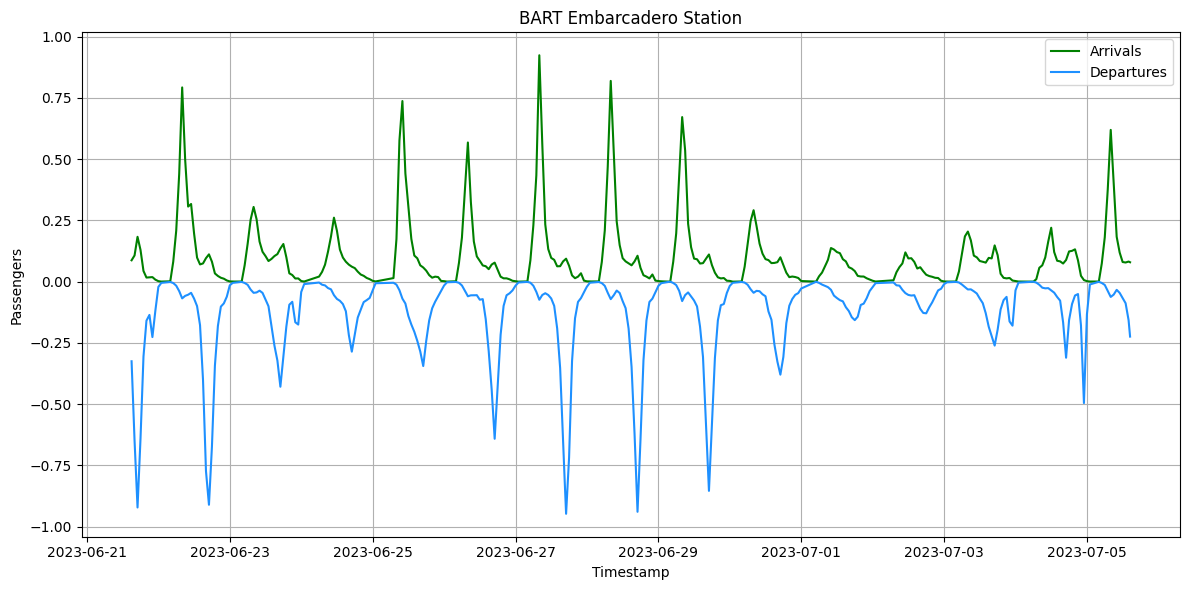

In [42]:
plt.figure(figsize=(12, 6))
duration = 672
plt.plot(df_commuters_normalized.index[:duration], df_commuters_normalized['arrival'][:duration], label='Arrivals', color='green')
plt.plot(df_commuters_normalized.index[:duration], df_commuters_normalized['departure'][:duration]*-1, label='Departures', color='dodgerblue')

# Customize the plot
plt.title("BART Embarcadero Station")
plt.xlabel("Timestamp")
plt.ylabel("Passengers")
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

In [43]:
df_commuters_normalized['departure'] = df_commuters_normalized['departure']*-1

In [44]:
df_commuters_normalized.to_csv('../data/bart.csv', index= True)

In [45]:
df_commuters_normalized.shape

(17533, 3)